Necessary Imports

In [2]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

!pip install -Uqq ipdb
import ipdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.8 MB/s eta 0:00:00


Selecting the device

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
device = torch.device('cpu')

The Neural Network

In [4]:
# define NN architecture
class Net(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_layer_dimensions, dropout):

        super(Net,self).__init__()

        # number of hidden nodes in each layer (512)

        self.dropout = nn.Dropout(dropout)
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.d_layer = [input_dim] + hidden_layer_dimensions + [output_dim]
        layer_list = [nn.Linear(self.d_layer[l], self.d_layer[l+1]) for l in range(len(self.d_layer) - 1)]
        self.linears = nn.ModuleList(layer_list)



    def forward(self,X):

        X = X.view(-1, self.input_dim)
        # relu(Wl x) for all hidden layer
        for layer in self.linears[:-1]:
            X = F.relu(layer(X))
            X = self.dropout(X)
        # softmax(Wl x) for output layer
        out = self.linears[-1](X)
        return F.log_softmax(out, dim=1)

Class to perform opertaions on the neural network

In [5]:
%pdb on
class Classifier:

  #def __init__(self):
    #model = Net()


  def load_data(self, batch_size = 64):
    # prepare data loaders

    # how many samples per batch to load
    self.batch_size = batch_size
    # percentage of training set to use as validation
    valid_size = 0.2
    # convert data to torch.FloatTensor
    transform = transforms.ToTensor()


    # choose the training and testing datasets
    train_validation_data = datasets.MNIST(root = 'data', train = True, download = True, transform = transform)
    self.test_data = datasets.MNIST(root = 'data', train = False, download = True, transform = transform)

    # obtain training indices that will be used for validation
    num_train_validation = len(train_validation_data)
    self.num_test = len(self.test_data)


    indices = list(range(num_train_validation))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train_validation))

    train_index, valid_index = indices[split:], indices[:split]

    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_index)
    valid_sampler = SubsetRandomSampler(valid_index)

    # prepare data loaders
    self.train_loader = torch.utils.data.DataLoader(train_validation_data, batch_size = batch_size,
                                              sampler = train_sampler, num_workers = 0)
    self.valid_loader = torch.utils.data.DataLoader(train_validation_data, batch_size = batch_size,
                                              sampler = valid_sampler, num_workers = 0)
    self.test_loader = torch.utils.data.DataLoader(self.test_data, batch_size = batch_size,
                                            num_workers = 0)



    self.image_height = self.test_data[0][0].shape[1]
    self.image_width = self.test_data[0][0].shape[2]

    self.input_dim = self.image_height * self.image_width

    self.output_dim = np.unique(self.test_data.targets).shape[0]

    print("data loaded")



  def create_model(self, opt = "adam", weight_decay = 0.001, learning_rate = 0.01, beta1 = 0.9, beta2 = 0.999, epsilon = 1e-8,hidden_layer_dimensions = [500, 250, 100], dropout = 0.2):

    self.model = Net(self.input_dim, self.output_dim, hidden_layer_dimensions, dropout).to(device)
    self.optimizers = {"sgd" : optim.SGD(self.model.parameters(), lr = learning_rate, momentum = 0.5, weight_decay = weight_decay),
                       "adam" : optim.Adam(self.model.parameters(), lr = learning_rate, betas = [beta1, beta2], eps = epsilon)}
    self.optimizer = self.optimizers[opt]

    print(self.model)

  def train_model(self, criterion = nn.NLLLoss() ,epochs = 15, log_interval = 200):

    losses, accuracies = dict(train = [], val = []), dict(train=[], val = [])

    for epoch in range(epochs):

      #train phase
      self.model.train() #set the model in training mode
      train_loss = 0.0
      train_corrects = 0
      total = 0

      for batchTrain, (images, labels) in enumerate(self.train_loader):
        train_loss = 0.0
        train_corrects = 0


        images = images.to(device)
        labels = labels.to(device)
        total = len(labels)
        # print(images.shape)

        self.optimizer.zero_grad()

        with torch.set_grad_enabled(True):
          outputs = self.model(images)
          _, preds = torch.max(outputs, 1)
          # print(outputs.device)
          # print(labels.device)
          # print(outputs)
          loss = criterion(outputs, labels)

          # backward + optimize only if in training phase
          loss.backward()
          self.optimizer.step()

          train_loss += loss.item() * images.size(0)
          train_corrects += torch.sum(preds == labels.data)

        if(batchTrain % log_interval == 0):
          losses["train"].append(train_loss/total)
          accuracies["train"].append(train_corrects/total)


        validation_loss = 0
        validation_corrects = 0
        total = 0

        for batchValidation, (images, labels) in enumerate(self.valid_loader):

          images = images.to(device)
          labels = labels.to(device)

          total += len(images)
          self.model.eval()


          with torch.set_grad_enabled(False):
            outputs = self.model(images)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            validation_loss += loss.item() * images.size(0)
            validation_corrects += torch.sum(preds == labels.data)

        if(batchTrain % log_interval == 0):
          losses["val"].append(validation_loss/total)
          accuracies["val"].append(validation_corrects/total)

    return losses, accuracies

  def plotConfusionMatrix(self, yTrue, yPred):
    # Create a heatmap of the confusion matrix
    confusion_mat = confusion_matrix(yTrue, yPred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

  def test_model(self, criterion = nn.NLLLoss(), log_interval = 200):

    self.model.eval()
    test_loss = 0
    test_corrects = 0
    yPred = []
    yTrue = []
    total = 0

    for batchTest, (images, labels) in enumerate(self.test_loader):

      images = images.to(device)
      labels = labels.to(device)
      yTrue += labels

      total += len(images)

      with torch.set_grad_enabled(False):
        outputs = self.model(images)
        _, preds = torch.max(outputs, 1)
        yPred += preds
        loss = criterion(outputs, labels)

        test_loss += loss.item() * images.size(0)
        test_corrects += torch.sum(preds == labels.data)


    self.plotConfusionMatrix(yTrue, yPred)
    return (test_loss/total, test_corrects/total)

Automatic pdb calling has been turned ON


In [6]:
def experiment(exp_id, batch_size = 64,opt = "sgd", weight_decay = 0.0, hidden_layer_dimensions = [500, 250, 100], dropout = 0.0, epochs = 15, log_interval = 200):

  print("experiment ", exp_id, "started")
  c = Classifier()
  c.load_data(batch_size = batch_size)
  c.create_model(opt = opt, weight_decay = weight_decay, hidden_layer_dimensions = hidden_layer_dimensions, dropout = dropout)
  (trainLosses, accuracies) = c.train_model(epochs = epochs, log_interval = log_interval)

  (test_loss, test_accuracy) = c.test_model()

  plt.title("Train & validation losses vs epochs")
  plt.plot(np.linspace(0, len(trainLosses["train"])-1, len(trainLosses["train"])), trainLosses["train"], label = "train losses")
  plt.plot(np.linspace(0, len(trainLosses["val"])-1, len(trainLosses["val"])), trainLosses["val"], label = "validation losses")
  plt.show()
  plt.title("Train & validation accuracies vs epochs")
  plt.plot(np.linspace(0, len(accuracies["train"])-1, len(accuracies["train"])), accuracies["train"], label = "train accuracies")
  plt.plot(np.linspace(0, len(accuracies["val"])-1, len(accuracies["val"])), accuracies["val"],label = "validation accuracies")
  plt.legend()
  plt.show()

  print("test loss is: ", test_loss)
  print("test accuracy is: ", test_accuracy)
  print("experiment: ", exp_id, " completed")

Experimenting the performance with different parameters.

Experiment: With best performing configuration in The Neural Network written from scratch, Obtaining an accuracy of 93% in 5 epochs

experiment  1 started


100%|██████████| 9912422/9912422 [00:00<00:00, 72603701.89it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 26588168.09it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 23077818.44it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 13322048.09it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

data loaded
Net(
  (dropout): Dropout(p=0.0, inplace=False)
  (linears): ModuleList(
    (0): Linear(in_features=784, out_features=500, bias=True)
    (1): Linear(in_features=500, out_features=250, bias=True)
    (2): Linear(in_features=250, out_features=100, bias=True)
    (3): Linear(in_features=100, out_features=10, bias=True)
  )
)


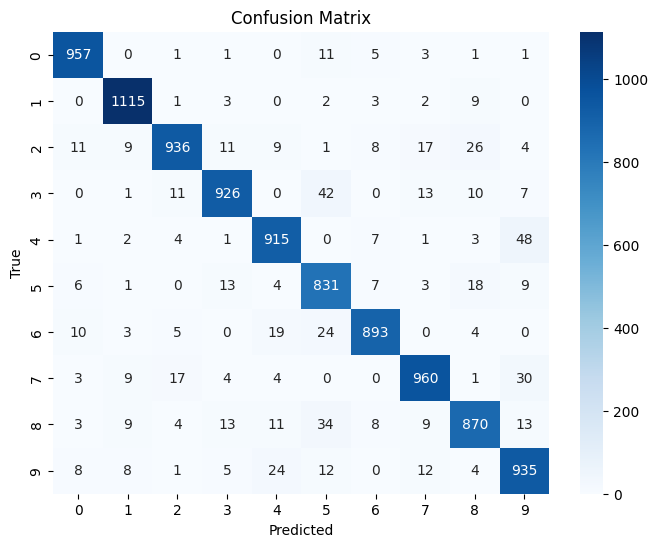

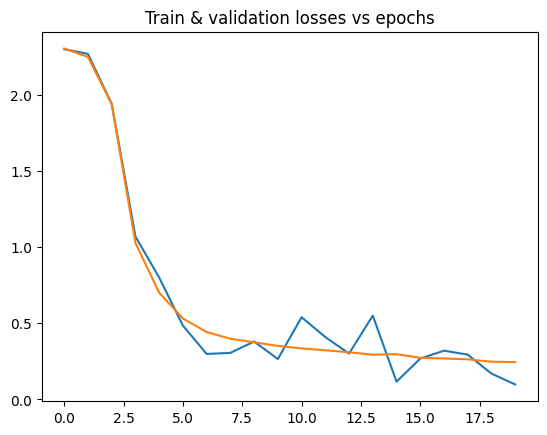

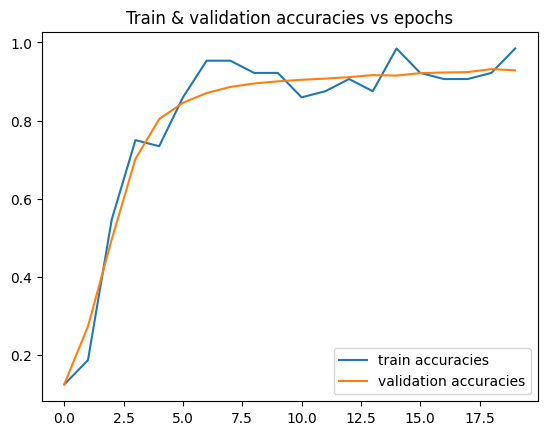

test loss is:  0.22002335015535354
test accuracy is:  tensor(0.9338)
experiment:  1  completed


In [7]:
#experiment : best performance from the Newral Network written from scratch mimicked
experiment(exp_id = 1, batch_size = 64,opt = "sgd", weight_decay = 0.0, hidden_layer_dimensions = [500, 250, 100], dropout = 0.0, epochs = 5, log_interval = 200)

Using Adam optimizer: the obtained accuracy is 94.6% on test data

experiment  2 started
data loaded
Net(
  (dropout): Dropout(p=0.0, inplace=False)
  (linears): ModuleList(
    (0): Linear(in_features=784, out_features=500, bias=True)
    (1): Linear(in_features=500, out_features=250, bias=True)
    (2): Linear(in_features=250, out_features=100, bias=True)
    (3): Linear(in_features=100, out_features=10, bias=True)
  )
)
1
0


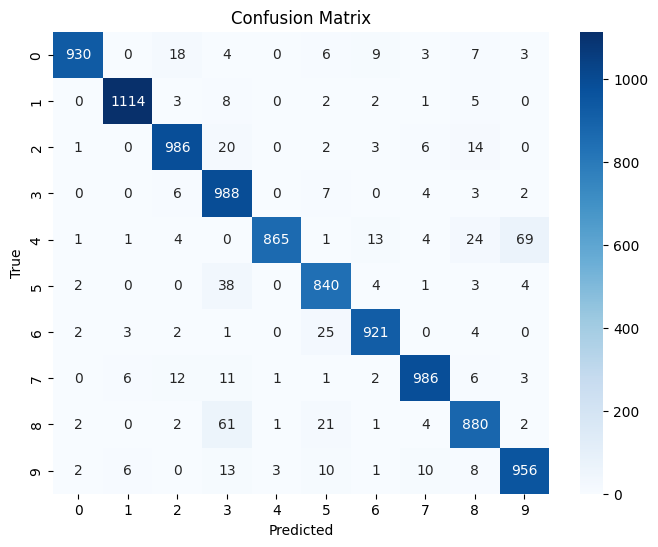

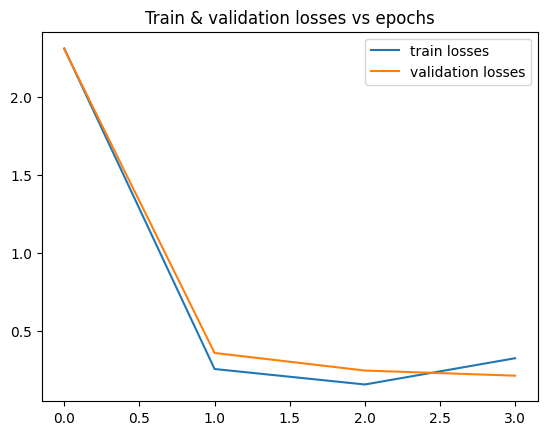

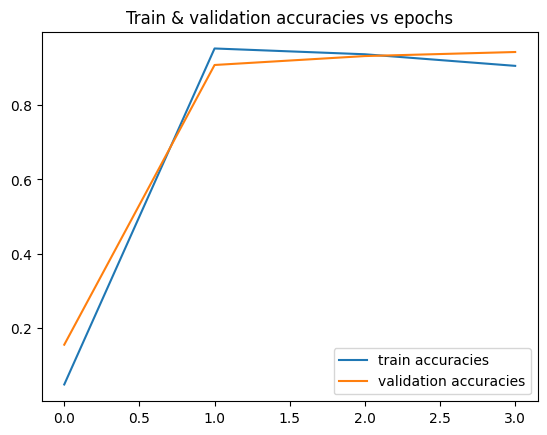

test loss is:  0.19614677001610398
test accuracy is:  tensor(0.9466)
experiment:  2  completed


In [ ]:
#experiment : using adam optimizer
experiment(exp_id = 2, batch_size = 64, opt = "adam", weight_decay = 0.0, hidden_layer_dimensions = [500, 250, 100], dropout = 0.0, epochs = 15, log_interval = 200)

Experiment: Using sgd as optimizer, and l2 regularizer
Obtained Accuracy: 64%

experiment  3 started
data loaded
Net(
  (dropout): Dropout(p=0.0, inplace=False)
  (linears): ModuleList(
    (0): Linear(in_features=784, out_features=500, bias=True)
    (1): Linear(in_features=500, out_features=250, bias=True)
    (2): Linear(in_features=250, out_features=100, bias=True)
    (3): Linear(in_features=100, out_features=10, bias=True)
  )
)
1
0


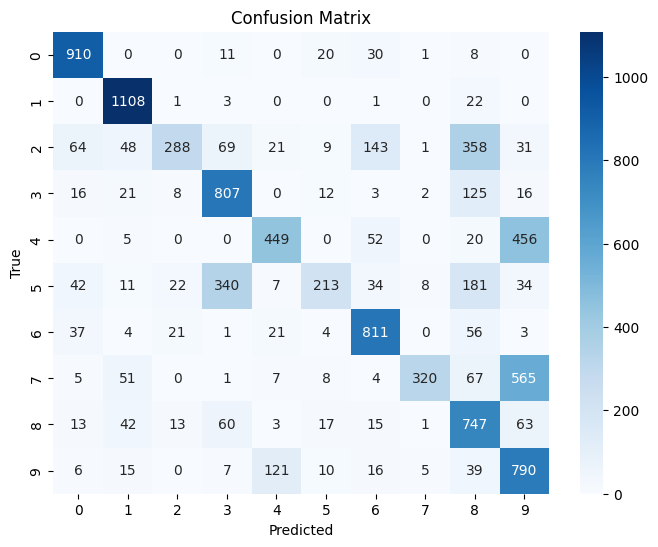

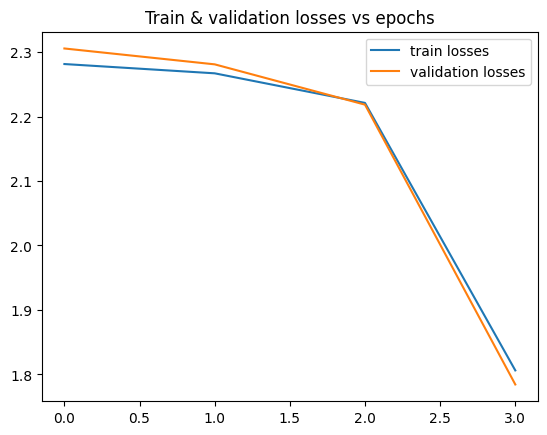

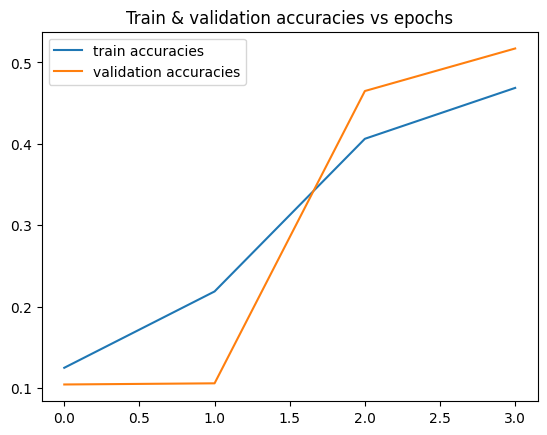

test loss is:  1.1016543467521667
test accuracy is:  tensor(0.6443)
experiment:  3  completed


In [ ]:
#experiment : using l2 regularizer
experiment(exp_id = 3, batch_size = 64, opt = "sgd", weight_decay = 0.01, hidden_layer_dimensions = [500, 250, 100], dropout = 0.0, epochs = 15, log_interval = 200)

Experiment: Using sgd as optimizer and dropout regularizer,
Obtained Accuracy: 76%

experiment  4 started
data loaded
Net(
  (dropout): Dropout(p=0.02, inplace=False)
  (linears): ModuleList(
    (0): Linear(in_features=784, out_features=500, bias=True)
    (1): Linear(in_features=500, out_features=250, bias=True)
    (2): Linear(in_features=250, out_features=100, bias=True)
    (3): Linear(in_features=100, out_features=10, bias=True)
  )
)
1
0


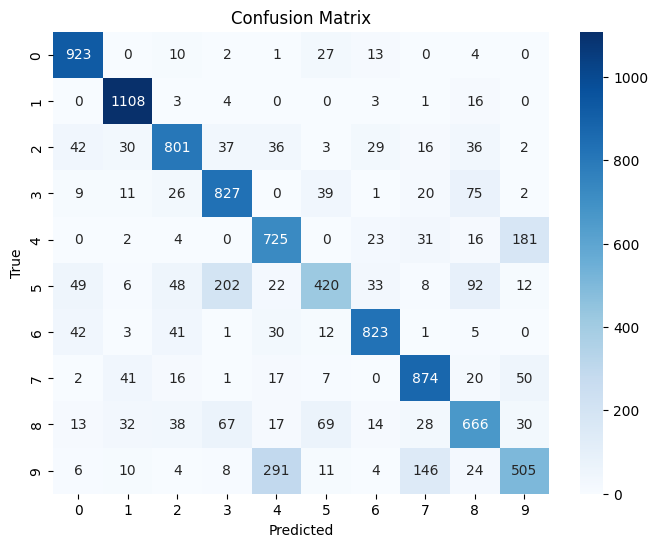

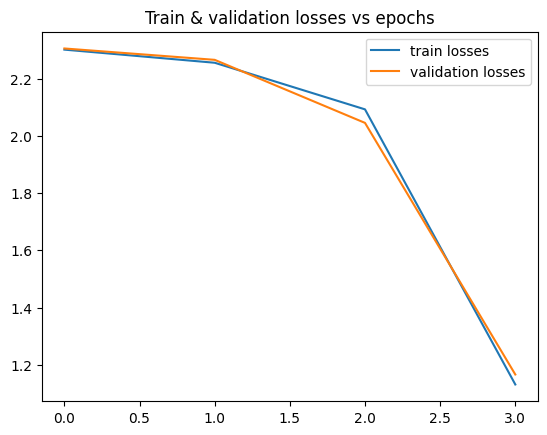

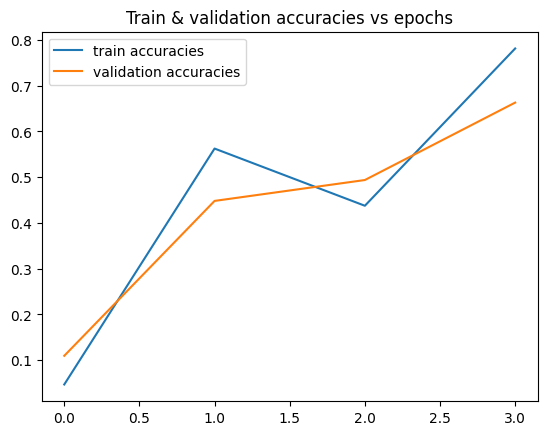

test loss is:  0.7571557574272155
test accuracy is:  tensor(0.7672)
experiment:  4  completed


In [ ]:
#experiment : using dropout
experiment(exp_id = 4, batch_size = 64, opt = "sgd", weight_decay = 0.00, hidden_layer_dimensions = [500, 250, 100], dropout = 0.02, epochs = 15, log_interval = 200)

Experiment: Using sgd as optimizer and both dropout and l2 regularizer,
Obtained accuracy: 74%

experiment  5 started
data loaded
Net(
  (dropout): Dropout(p=0.02, inplace=False)
  (linears): ModuleList(
    (0): Linear(in_features=784, out_features=500, bias=True)
    (1): Linear(in_features=500, out_features=250, bias=True)
    (2): Linear(in_features=250, out_features=100, bias=True)
    (3): Linear(in_features=100, out_features=10, bias=True)
  )
)
1
0


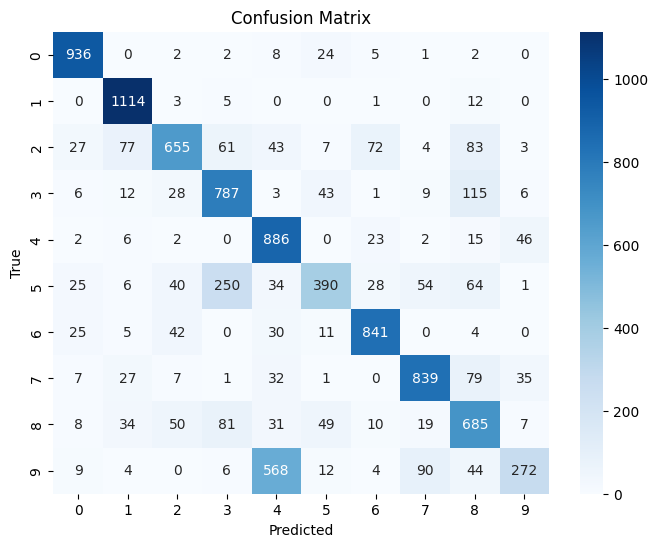

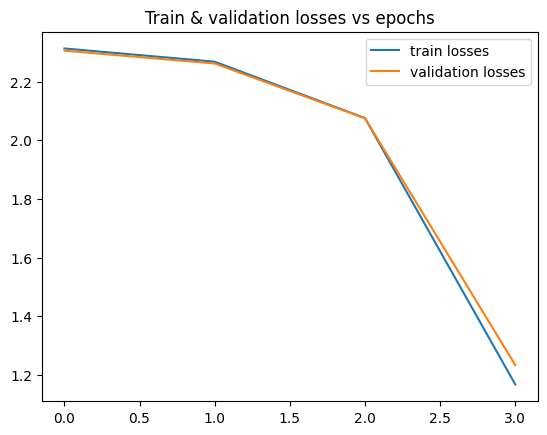

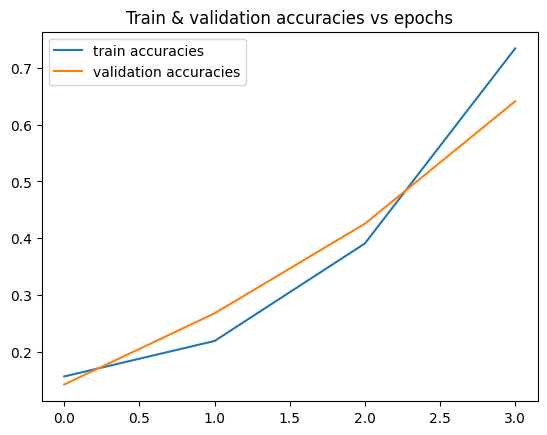

test loss is:  0.8179346004486084
test accuracy is:  tensor(0.7405)
experiment:  5  completed


In [ ]:
#experiment : using both
experiment(exp_id = 5, batch_size = 64, opt = "sgd", weight_decay = 0.01, hidden_layer_dimensions = [500, 250, 100], dropout = 0.02, epochs = 1, log_interval = 200)

Observation: The SGD and Adam performs realitively very similar i.e the accuracy difference is lower. But performance with use of regilarizers and optimizers are not significantly found to be improved.